# Voice Activity Detection

<!-- - extract basic speech features suitable for voice activity detection (VAD)

- utilize them to train two simple VAD classifiers -->

In this notebook, we explore Voice Activity Detection (VAD), a fundamental technique in speech processing used to distinguish between speech and non-speech segments in an audio signal. VAD is essential for various speech applications, such as speech recognition, speaker identification, and audio compression, where identifying the presence of speech helps to optimize resources and improve performance.

We begin by extracting basic speech features that are commonly used for VAD, including:

- **Zero-Crossing Rate (ZCR)**: This feature measures how frequently the signal changes sign (crosses the zero axis) over a frame. It captures the temporal structure of the signal and is useful in distinguishing between voiced and unvoiced sounds.

- **Energy**: The energy of the signal within a frame reflects its loudness or intensity. Speech frames tend to have higher energy than non-speech frames, making this feature valuable for identifying speech activity.

- **One-Lag Autocorrelation**: Autocorrelation measures the similarity of a signal with a delayed version of itself. One-lag autocorrelation specifically evaluates the correlation between consecutive samples, capturing periodicity in the signal that is often present in voiced speech.

After feature extraction, we use these features to train and evaluate two simple VAD classifiers. These classifiers aim to classify each frame of the audio signal as either "speech" or "no speech," based on the extracted features.

By the end of this notebook, you will have an understanding of how to:

Extract fundamental speech features.
Utilize these features to build basic VAD classifiers.



In [6]:
from utils import *

## prepare the speech signal

### loading

In [7]:
# Read the audio file and sampling rate
Fs_target = 16000
Fs,data = wav.read('hello.wav')
data = data[:, 0] # stereo to mono

# Transform signal from int16 (-32768 to 32767) to float32 (-1,1)
if type(data[0]) == np.int16:
    data = np.divide(data,32768,dtype=np.float32)

# Make sure the sampling rate is 16kHz
if not (Fs == Fs_target):
    data = sig.resample_poly(data,Fs_target,Fs)
    Fs = Fs_target

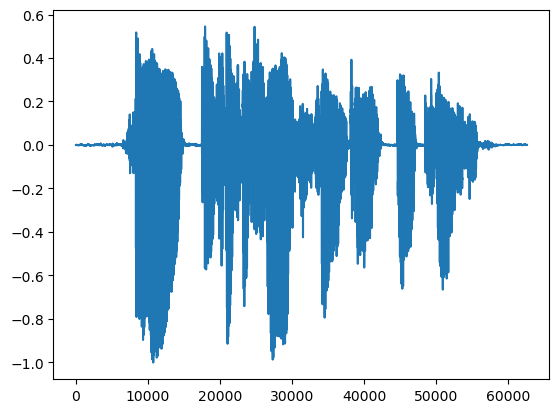

In [8]:
plt.plot(data)

### windowing

In [9]:
# Split the data sequence into windows.
frame_length_ms = 25 # in miliseconds
hop_length_ms = 12.5 # in miliseconds

frame_length = int(np.around((frame_length_ms/1000)*Fs))# 25ms in samples
hop_size = int(np.around((hop_length_ms/1000)*Fs))# 12.5 ms (25/2 ms) in samples (50% overlap)

frame_matrix = windowing(data, frame_length, hop_size, 'hamming')


In [10]:
frame_matrix.shape

(400, 311)

## Features

### Zero-crossing rate (ZCR)
The zero-crossing rate is defined as the number of instances that the sign of the product of two consequtive samples within a frame is negative. i.e.,
\begin{equation}
 zcr = \sum_{i=1}^{N} [sign(s[n]s[n-1]) < 0]
\end{equation}

In [11]:
def zcr(frame):
    # Count the number of times that a signal crosses the zero-line
    #Inputs: frame: the input signal frame
    #Outputs: zcr: The zero-crossing rate of a zero-mean frame.
    # (I.e. Remember to remove the mean from the frame!!)

    zcr = 0
    frame = frame - np.mean(frame)
    for i in range(1, len(frame)):
        if (frame[i] * frame[i-1]) < 0:
            zcr = zcr + 1

    return zcr

In [12]:
# Implement zero-crossing rate (ZCR) computation
zcr_vec = np.zeros((1, len(frame_matrix[0])))
for iFrame in range(len(frame_matrix[0])):
    zcr_vec[0,iFrame] = zcr(frame_matrix[:,iFrame])

### Energy
The average energy $e$ of a signal $s[n]$ of length $N$ is defined as.
\begin{equation}
	e = \frac{1}{N}\sqrt{\sum_{i=1}^{N} s[i]^2}
\end{equation}

In many cases, it is desirable to remove the DC component (mean value) of the frame before computing the energy.


In [13]:
def energy(frame):
    #Compute the energy of a given frame (with mean removed)
    #Inputs: frame: the input signal frame
    #Outputs: energy: Frame energy

    frame = frame-np.mean(frame)
    energy = np.sqrt(np.sum(np.power(frame,2)))

    return energy

In [14]:
# Implement energy computation
energy_vec = np.zeros((1,len(frame_matrix[0])))
for iFrame in range(len(frame_matrix[0])):
    energy_vec[0,iFrame] = energy(frame_matrix[:,iFrame])

### Peak values of autocorrelation and cepstrum 

In [15]:
def F0_autocorr(frame,fs,f0_min,f0_max,vuv_threshold):

    frame = np.array(frame)
    frame = frame-np.mean(frame)
    max_lag = int(np.ceil(fs/f0_min))
    min_lag = int(np.floor(fs/f0_max))
    r = np.correlate(frame,frame, mode='full')
    r = r/np.amax(np.absolute(r))
    r = r[(len(frame)-1):]
    r = r[min_lag:max_lag]
    ac_peak_val = np.amax(r)
    ind = np.argmax(r)

    if ac_peak_val > vuv_threshold:
        f0 = fs/(min_lag+ind)
    else:
        f0 = 0

    return f0,ac_peak_val

In [16]:
def F0_cepstrum(frame,fs,f0_min,f0_max,vuv_threshold):

    frame = np.array(frame)
    max_lag = int(np.ceil(fs/f0_min))
    min_lag = int(np.floor(fs/f0_max))
    eps = 0.00001
    c = np.real(np.fft.ifft(np.log10(np.absolute(np.power(np.fft.fft(frame),2) + eps))))
    c = c[min_lag:max_lag]
    cepstral_peak_val = np.amax(np.absolute(c))
    ind = np.argmax(c)
    if cepstral_peak_val > vuv_threshold:
        f0 = fs/(min_lag+ind)
    else:
        f0 = 0

    return f0,cepstral_peak_val

In [17]:
# Obtain peak values of autocorrelation and cepstrum
f0_max = 200
f0_min = 50

F0_ac = np.zeros((1,len(frame_matrix[0])))
F0_cep = np.zeros((1,len(frame_matrix[0])))

ac_peak_vec = np.zeros((1,len(frame_matrix[0])))
ceps_peak_vec = np.zeros((1,len(frame_matrix[0])))

for iFrame in range(len(frame_matrix[0])):
    F0_ac[0,iFrame],ac_peak_vec[0,iFrame] = F0_autocorr(frame_matrix[:,iFrame],Fs,f0_min,f0_max,0)
    F0_cep[0,iFrame],ceps_peak_vec[0,iFrame] = F0_cepstrum(frame_matrix[:,iFrame],Fs,f0_min,f0_max,0)

## Concatenate features

In [18]:
# Concatenate all six feature vectors you have already calculated (ZCR, Energy,F0_ac, F0_cep, ac_peak_vec and ceps_peak_vec)
# Rows represent features, and columns represent frame number.
vad_input = np.concatenate((zcr_vec,energy_vec,ac_peak_vec,ceps_peak_vec,F0_ac,F0_cep),axis=0)

In [19]:
vad_input.shape

(6, 311)

## Delta and delta-deltas to input features
The delta- and delta-deltas features of a signal are defined as their first and second time derivatives. The accurate estimation of time derivatives for discrete signals can be tricky, but for most purposes first-order central finite difference coefficients are sufficient:
$$
\begin{equation}
	f^\prime(x_0) \approx -\frac{1}{2}f(x_{-1}) + \frac{1}{2}f(x_{+1})

\end{equation}
$$
and 
$
\begin{equation}
	f^{\prime\prime}(x_0) \approx f(x_{-1}) -2f(x_{0})   +f(x_{+1})
\end{equation}
$
In practice, the computation of delta- and delta-deltas parameters is most easily obtained with the 'lfilter' function (scipy.signal) by setting the FIR filter coefficients corresponding to those of above equations.

In [20]:
def add_deltas_deltadeltas(vad_input):
    #Add delta and delta-delta features to features of input matrix. Rows represent features, and columns represent frames.
    #Inputs: vad_input: m x n matrix with m features and n frames
    #Outputs: output: 3*m x n matrix whose rows contain original features, delta and delta-delta features

    #Delta and Delta-delta filters:
    #https://en.wikipedia.org/wiki/Finite_difference_coefficient
    filt_dx = [0.5, 0, -0.5]
    filt_ddx = [1, -2, 1]
    output_size = (3*len(vad_input), len(vad_input[0]))
    output = np.zeros(output_size)

    for i in range(len(vad_input)):
        temp = np.zeros((3,len(vad_input[0])))
        temp[0,:] = vad_input[i,:] #Select a feature row
        temp[1,:] = sig.lfilter(filt_dx,1,vad_input[i,:])#Compute deltas
        temp[2,:] = sig.lfilter(filt_ddx,1,vad_input[i,:])#Compute delta-deltas
        output[(i*3):((i+1)*3),:] = temp #add to output

    return output

In [21]:
#Add deltas and delta-deltas to input
vad_input = add_deltas_deltadeltas(vad_input)

In [22]:
vad_input.shape

(18, 311)

## Normalization

Normalize each input parameter to zero-mean and unit variance vectors

In [23]:
def normalize(M):
    # Normalize (zero-mean and unit variance) the values of input matrix M for each row.

    output = np.zeros(M.shape)

    for i in range(len(M)):
        tmp = M[i,:]
        tmp = tmp - np.mean(tmp)
        tmp = tmp/np.linalg.norm(tmp,ord=2)
        output[i,:] = tmp
    
    return output

In [24]:
vad_input = normalize(vad_input)

## Read ground truth

In [25]:
def read_ground_truth():
    #Target files must be in the same directory
    with open('ground_truth','r') as f:
        data = f.read() 
    targets = np.array([int(i) for i in data.split()])
    targets = targets.reshape((1,len(targets)))
    return targets

## Linear classifiers

We will train two different classifiers with the toy-sized data set of a single utterance for out experiments. A linear classifier learns a set of weights $w$ that form a linear combination mapping of an input vector $x_k$ into a target output value $y_k$:
\begin{equation}
 y_k = x_k^Tw
\end{equation}

Classification is done by "thresholding" $y$  according to the zero-level. A simple linear classifier is trained with training data with inputs on matrix $X = [x_0, x_1, \ldots]$ corresponding to a labeled target vector $y = [y_0, y_1, \ldots]$ with the "pseudo inverse" of $X$:
\begin{equation}
	w = (XX^T)^{-1}Xy^T
\end{equation}

### Perceptron

Perceptron is another formulation of a linear classifier. Perceptron also maps the linear combination of the input vector into the target class of a binary value:
\begin{align}
	f(x) &= 1, \qquad \text{if } x^Tw > 0 \\
	     &= 0, \qquad \text{otherwise}
\end{align}
The difference between the least-squares linear classifier and the perceptorn is the learning algorithm. Within the pseudo-inverse classifier, the analytic least-squares solution can be derived by minimizing the prediction error before thresholding; within the perceptron model the weights are adjusted iteratively based on the classification error  obtained after thresholding.

In [26]:
def perceptron_training(vad_input, outputs):

    MAX_ITER = 100000
    w = np.zeros((1,len(vad_input)))
    y = np.zeros((1,len(outputs)))

    #Training
    for iter in range(MAX_ITER):
        #Compute weight gradient
        dw = np.matmul((outputs - y), vad_input.T) / len(vad_input[0])

        #update weights
        w = w + dw

        #Apply non-linearity
        y = (np.matmul(w, vad_input) > 0)

    print('Perceptron training complete after '+str(iter)+' iterations.')

    return w

## Training

Train a perceptron model with the computed input parameters for VAD.

In [40]:
#Load target output
vad_target = read_ground_truth()

#Add bias vector to input parameters
vad_input = np.concatenate((np.ones((1,len(vad_input[0]))),vad_input),axis=0)

#Train a perceptron model (linear classifier with output non-linearity)
w_perceptron = perceptron_training(vad_input,vad_target)

#Train a linear classifier
w_linear = np.matmul((vad_target - 0.5),np.linalg.pinv(vad_input))

Perceptron training complete after 99999 iterations.


In [42]:
#Use the obtained models to make the predictions for perceptron

thresh_perceptron = 0
vad_perceptron = (np.matmul(w_perceptron,vad_input) > thresh_perceptron).astype(np.int32)
error_perceptron = np.mean(np.absolute(vad_perceptron - vad_target))
print('Error of perceptron: ' + str(error_perceptron))

Error of perceptron: 0.0


In [44]:
# Make the predictions for linear classifier

thresh_linear = 0.0
vad_linear = (np.matmul(w_linear,vad_input) > thresh_linear).astype(np.int32)
error_linear = np.mean(np.absolute(vad_linear - vad_target))
print('Error of classifier: ' + str(error_linear))

Error of classifier: 0.08360128617363344


## Visualizations

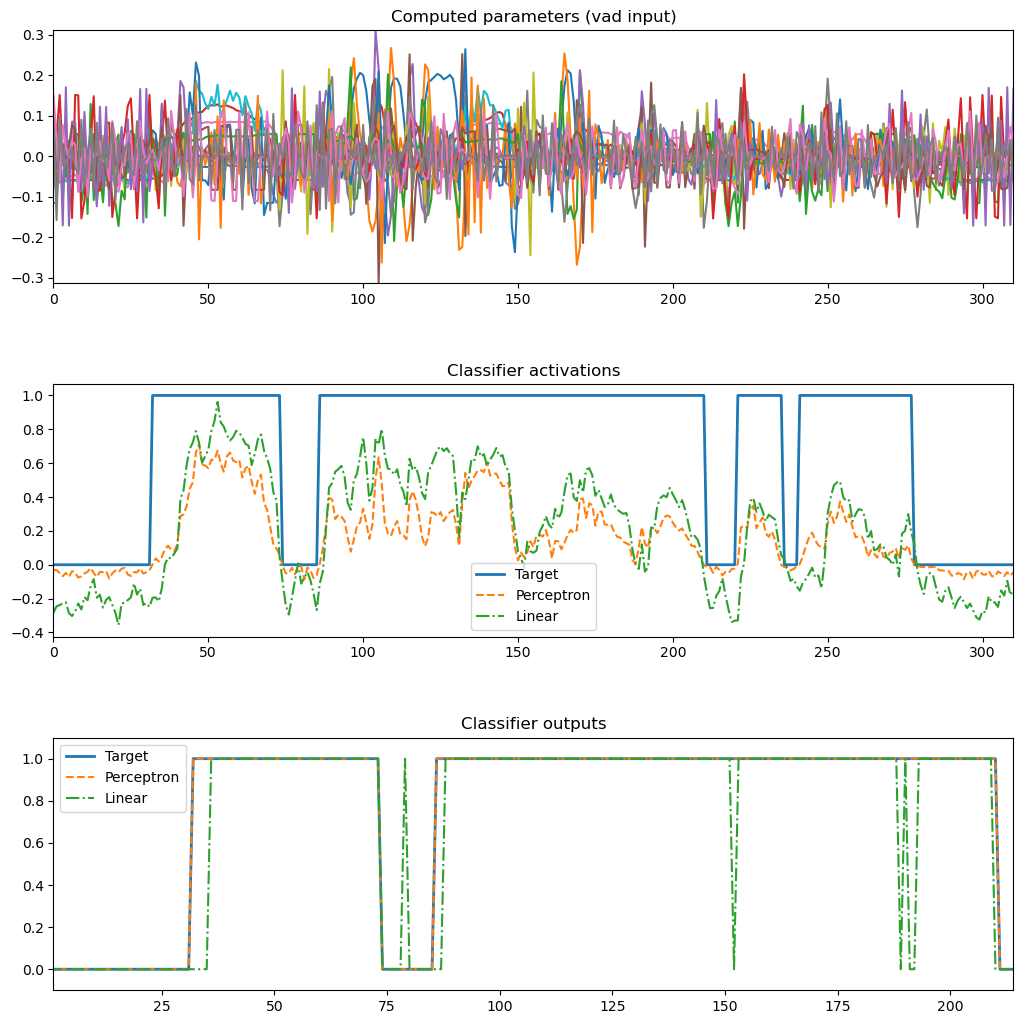

In [45]:
# visualize your results

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
fig.tight_layout()

# Plot the input vectors
plt.subplot(3,1,1)
plt.plot(vad_input[1:,:].T)
plt.autoscale(enable=True, axis='both', tight=True)
plt.title('Computed parameters (vad input)')

# Plot the classifier activation values (y = X.transpose * W) for each frame (without classification)

plt.subplot(3,1,2)
plt.plot(vad_target.T,linewidth=2)
plt.plot(np.matmul(w_perceptron,vad_input).T,'--')
plt.plot(np.matmul(w_linear,vad_input).T,'-.')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(('Target','Perceptron','Linear'))
plt.title('Classifier activations')

# Plot the ground truth (target) vector and obtained classification results for both classifiers
plt.subplot(3,1,3)
plt.plot(vad_target.T,linewidth=2)
plt.plot(vad_perceptron.T,'--')
plt.plot(vad_linear.T,'-.')
plt.axis([1,214,-0.1,1.1])
plt.legend(('Target','Perceptron','Linear'))
plt.title('Classifier outputs')


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show(block=False)